# *Water Detection*: example at Huallaga River (Meander),Peru.
Water detection identifies the presence or absence of water in a given area. It is crucial for various applications in multiple sectors, including environmental monitoring, agriculture, urban planning and disaster management.
Accurate water sensing allows us to assess water availability, monitor changes in water bodies, predict floods or droughts, and manage water resources effectively.
The code is based on the compilation of satellite images (more than 30 years old) and determining areas of water, sand, and other elements. For this analysis, CoastSat's code is being used.

Review research:
Kilian Vos, Kristen D. Splinter, Mitchell D. Harley, Joshua A. Simmons, Ian L. Turner. CoastSat: A Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery, Environmental Modeling & Software, Volume 122, 2019, 104528, ISSN 1364-8152, https://doi.org/10.1016/j.envsoft.2019.104528.

The software application refers to a sandy beach, with various cases being validated. Future projects it is expected to implement this code initially focused on coasts and expand it to rivers.


In [1]:
!pip install earthengine-api


# Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from waterdetection import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools

# Retrieval of the images from GEE

Define the region of interest (`polygon`), the date range (`dates`) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

To create you ROI polygon you can either:
- enter the coordinates manually as in the example below (making sure the first and last coordinate are the same);
- go to [geojson.io](https://geojson.io), draw a polygon for your area of interest and export it as a GeoJSON and then read it with the function `SDS_tools.polygon_from_geojson()`.
- go to Google MyMaps, draw a polygon and export it as kml and then read it with the function `SDS_tools.polygon_from_kml()`.
- Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).


In [3]:
# region of interest (longitude, latitude)
polygon = [[[-76.12260456749439, -5.8540712326457225],
            [-76.12260456749439, -5.9130022516166605],
            [-76.05911885559713, -5.9130022516166605],
            [-76.05911885559713, -5.8540712326457225],
            [-76.12260456749439,-5.8540712326457225]]]
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# or load from .geojson
# geojson_polygon = os.path.join(os.getcwd(), 'examples', 'NARRA_polygon.geojson')
# polygon = SDS_tools.polygon_from_geojson(geojson_polygon)
dates = ['2023-06-01', '2023-08-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['S2']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'
# name of the site
sitename = 'Huallaga'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
         'landsat_collection': collection}
# optionally, you can select your Sentinel-2 tile to avoid duplicates from multiple tiles
# inputs['S2tile'] = '56HLH'
# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Number of images available between 2023-06-01 and 2023-08-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 10 images
  Total to download: 10 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [4]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

Number of images available between 2023-06-01 and 2023-08-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 10 images
  Total to download: 10 images

S2: 10 images
100%
Satellite images downloaded from GEE and save in /Users/krishnapatil/Desktop/Remote_sensing/waterdetection/data/Huallaga


**If you have already retrieved the images**, just load the metadata file by only running the section below

In [5]:
metadata = SDS_download.get_metadata(inputs)

# River-line extraction
The river zone is the interface between water and sand captured during image acquisition. Based on the code made by CoastSat and its coast detection algorithm with sub-pixel resolution, pre-processed satellite images can detect it. For this, the tool defines two central steps: (i) classification of images into four classes and (ii) edge segmentation with subpixel resolution.

Recommendation:
- see http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system.
- Make sure that your are using **cartesian coordinates** (eastings and northings) and **not spherical coordinates** (lat,lon like WGS84).
- It is important that you use a local projection otherwise you may introduce errors when intersecting the shorelines with the cross-shore transects.


In [6]:
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # distance around clouds where shoreline can't be mapped
    'output_epsg': 32718,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
    
    # add the inputs defined previously
    'inputs': inputs,
}

### [OPTIONAL] Create timelapse animation of RGB images  
Before mapping River-lines, the users can generate true color images for their ROI and save them as .jpg for visualisation. There is also code to make an .mp4 animation. The pre-processed .jpg images are cloud masked and pansharpened/down-sampled and are saved under *./data/sitename/jpg_files/preprocessed*. 

In [7]:
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
S2: 10 images
100%
Satellite images saved as .jpg in /Users/krishnapatil/Desktop/Remote_sensing/waterdetection/data/Huallaga/jpg_files/preprocessed


In [8]:
# create MP4 timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_RGB.mp4'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'preprocessed')
fps = 0.5 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2700, 1350) to (2704, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x13f008c00] Stream #0: not enough frames to estimate rate; consider increasing probesize


Animation has been generated (using 0 frames per second) and saved at /Users/krishnapatil/Desktop/Remote_sensing/waterdetection/data/Huallaga/Huallaga_animation_RGB.mp4


### Digitize a reference River-line [HIGHLY RECOMMENDED]
Creates a reference River-line which helps to identify outliers and false detections. 

In [9]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference River-line

Reference shoreline has been saved in /Users/krishnapatil/Desktop/Remote_sensing/waterdetection/data/Huallaga


### Batch River-line detection
Extracts the 2D lines from the images in the spatial reference system specified by the user.

In [10]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
S2:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [11]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

0 duplicates
0 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [12]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

Again, we can create a timelapse animation showing the movement of the River-line:

In [13]:
# create MP4 timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_shorelines.mp4'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'detection')
fps = 0.5 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2205, 1197) to (2208, 1200) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x14a809200] Stream #0: not enough frames to estimate rate; consider increasing probesize


Animation has been generated (using 0 frames per second) and saved at /Users/krishnapatil/Desktop/Remote_sensing/waterdetection/data/Huallaga/Huallaga_animation_shorelines.mp4


Simple plot of the mapped River-lines. The coordinates are stored in the output dictionary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

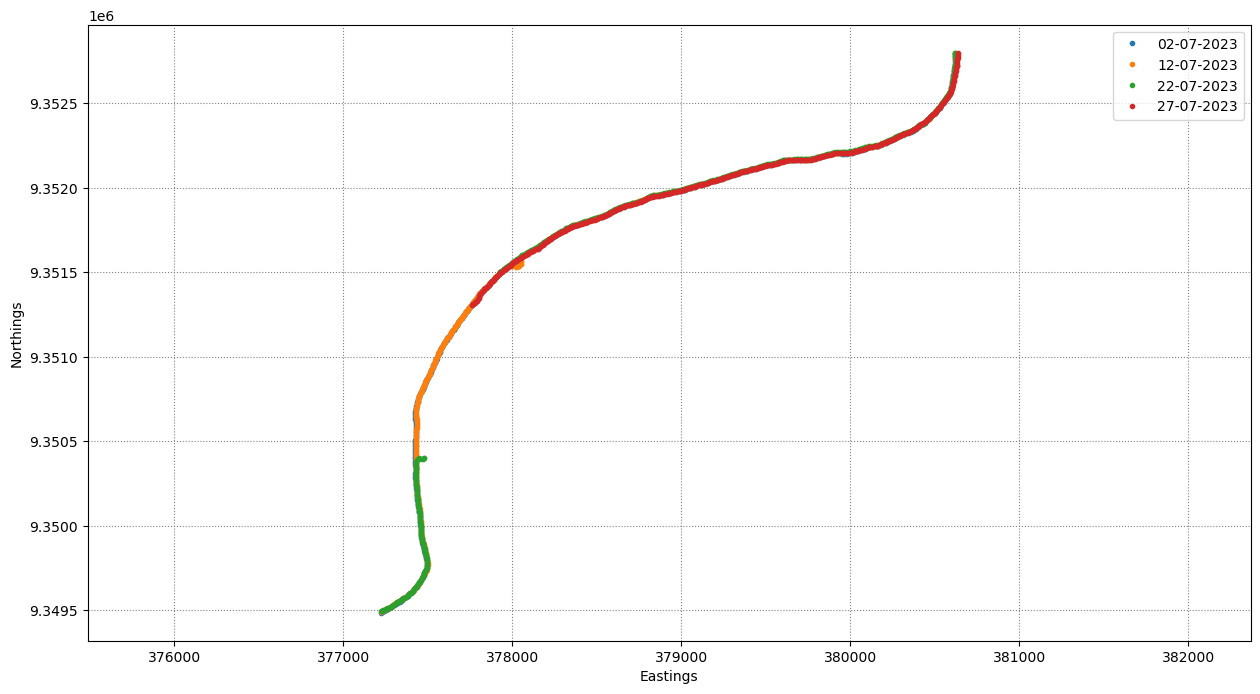

In [14]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend();

Exporting riverline data at various time intervals into shapefiles

In [15]:
import geopandas as gpd
from shapely.geometry import LineString

# Convert shorelines data to LineString geometries
geometries = [LineString(sl) for sl in output['shorelines']]
dates_str = [date.strftime('%Y-%m-%d') for date in output['dates']]  # Convert dates to strings

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'date': dates_str}, geometry=geometries)

# Save the GeoDataFrame to a shapefile
gdf.to_file("shorelines.shp")